# Sequential decision problems in ecology: a hands-on introduction

Where do models come from? Why do we create them, and what purpose do they serve? Ecological processes are complex, models seek only to capture salient features at spatial, temporal and organization scales considered relevant.

Process-based simulations provide an excellent test case of our methods for modeling and decision-making. In real world empirical systems, we never have access to a 'true' model -- multiple models with substantially different implications may 'fit' available data equally well, and a model that has appeared to match empricial data to date can suddenly be wrong.  There is no such thing as 'verifying' or 'validating' a model -- all models are approximations -- leaky abstractions of more complex processes.  But applied to a simulation, a generative process, we can come close.  


Here we consider a simulation of a fish population from which we wish to extract a sustainable harvest.  The underlying model is not visible to us, instead we can empirically observe and manipulate the system to try and come up with a model of the system behavior.  We could use such a model to predict future values of the system, speculate about mechanisms driving the dynamics, and determine an optimal harvesting strategy.  Here is our model 'environment':

In [6]:
from fish import fish
env = fish()


We can simulate a step forward in time of this environment using the time step method.  This takes an optional 'harvest effort' and returns an observation of the population in the next time step, as well as a 'utility' or reward from any harvest, and an indicator of whether we have hit a "game over" condition such as extinction of the population:

In [7]:
env.time_step()


(array([0.50962228]), 0.0, False)

We can rerun the step above again and again to go further forward in time. Each run updates the internal state of the system, returning the most recent observation.  

Let's try a simulation of a few timesteps of underlying process under a high fishing rate:

In [8]:
env.reset()
for t in range(0,10):
    obs, reward, terminated = env.time_step(1)
    print(obs)


[0.44814444]
[0.41262764]
[0.39607012]
[0.34951377]
[0.31719375]
[0.29038835]
[0.27607107]
[0.26569855]
[0.22631848]
[0.20444494]


Let's plot these values to get a better sense of the overall dynamics.  The code below considers no harvest effort, `action = 0`, and naturally the reward derived from this is zero.  After exploring this case, consider various different harvest policies to see which produces the greatest reward.  Is the most aggressive harvest strategy the most profitable?

Total reward for simulation under this policy is:
0.0


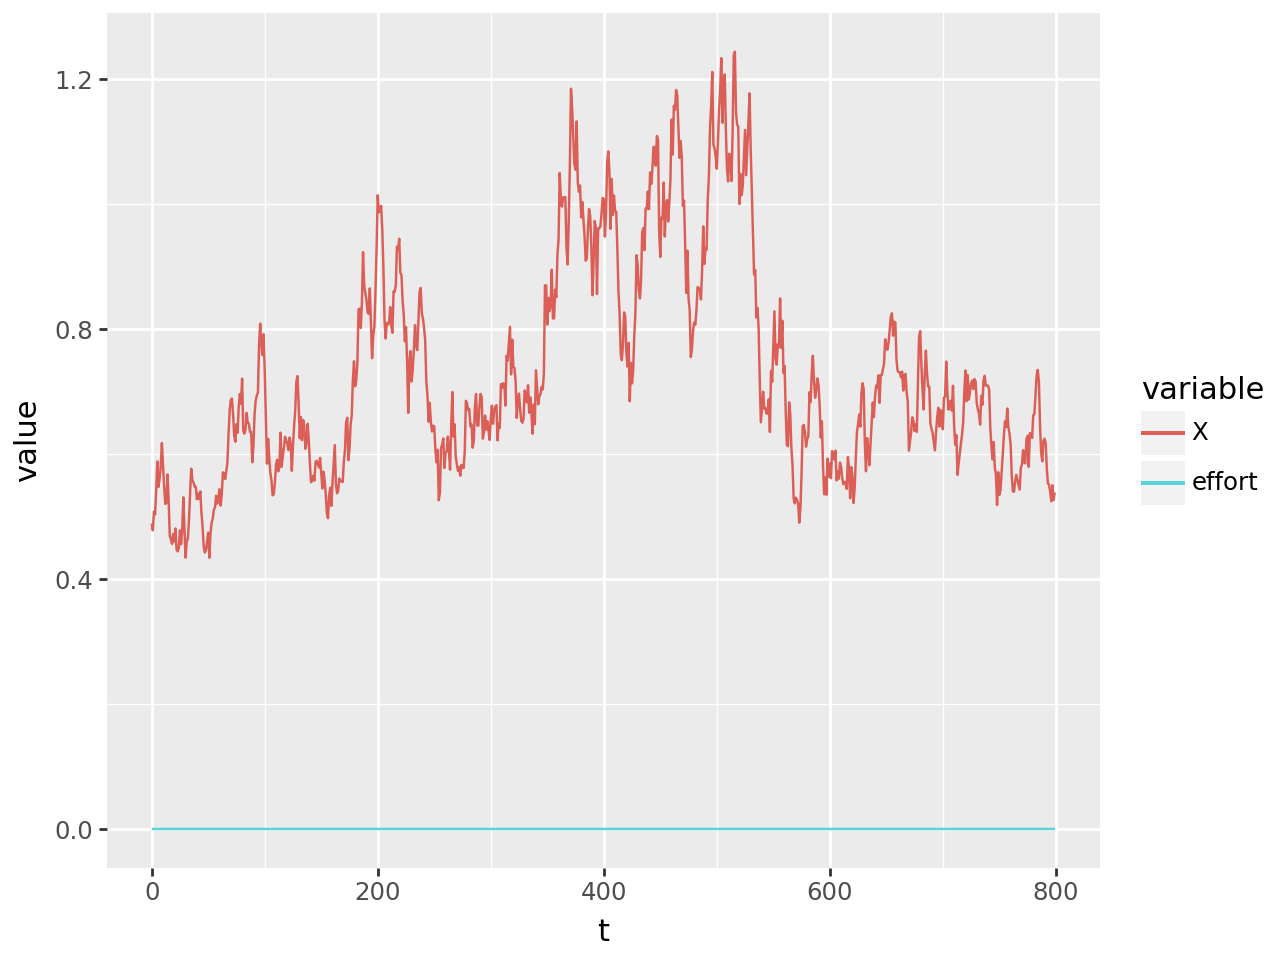

In [14]:
from utils import plot_sim

action = 0.

# initial conditions
df = []
episode_reward = 0
env.reset()

# simulate for Tmax timesteps:
for t in range(env.Tmax):
  obs, reward, done = env.time_step(action)
  episode_reward += reward
  df.append([t, episode_reward, action, obs])
  if done:
    break

print("Total reward for simulation under this policy is:")
print (episode_reward)
plot_sim(df)

A natural next step here here would be to build a model of this system to predict future values and guide decisino making.  A simple autoregressive model with Gaussian noise happens to fit the above dynamics very well with few parameters, but provides little insight into how these dynamics would behave under a harvest.  In a longer tutorial, we could try a variety of model estimation and comparison approaches.  


Here we take a different approach.  Even in the absence of a specific model, a manager can base harvest effort on past experience.  We define an "agent" which observes the estimated stock size each timestep and proposes a harvest effort.  A very simple agent will simply take the same action regardless of the observation. Having experienced several different harvests in the exploration above, you may already have a good idea of what values to try.   


In [25]:
import numpy as np
# A simple agent
class some_agent:
    def __init__(self, effort):
        self.effort = effort

    def predict(self, obs, **kwargs):
        return self.effort

# Bob always gives the same action, regardless of the observation:
bob = some_agent(.2)
bob.predict(.5), bob.predict(.1)

(0.2, 0.2)

Let's see how well "bob" does in managing this ecosystem.  For convenience, we'll use a helper function for the simulation so that we don't have to keep writing out the same "for" loop:

14.537946475532719


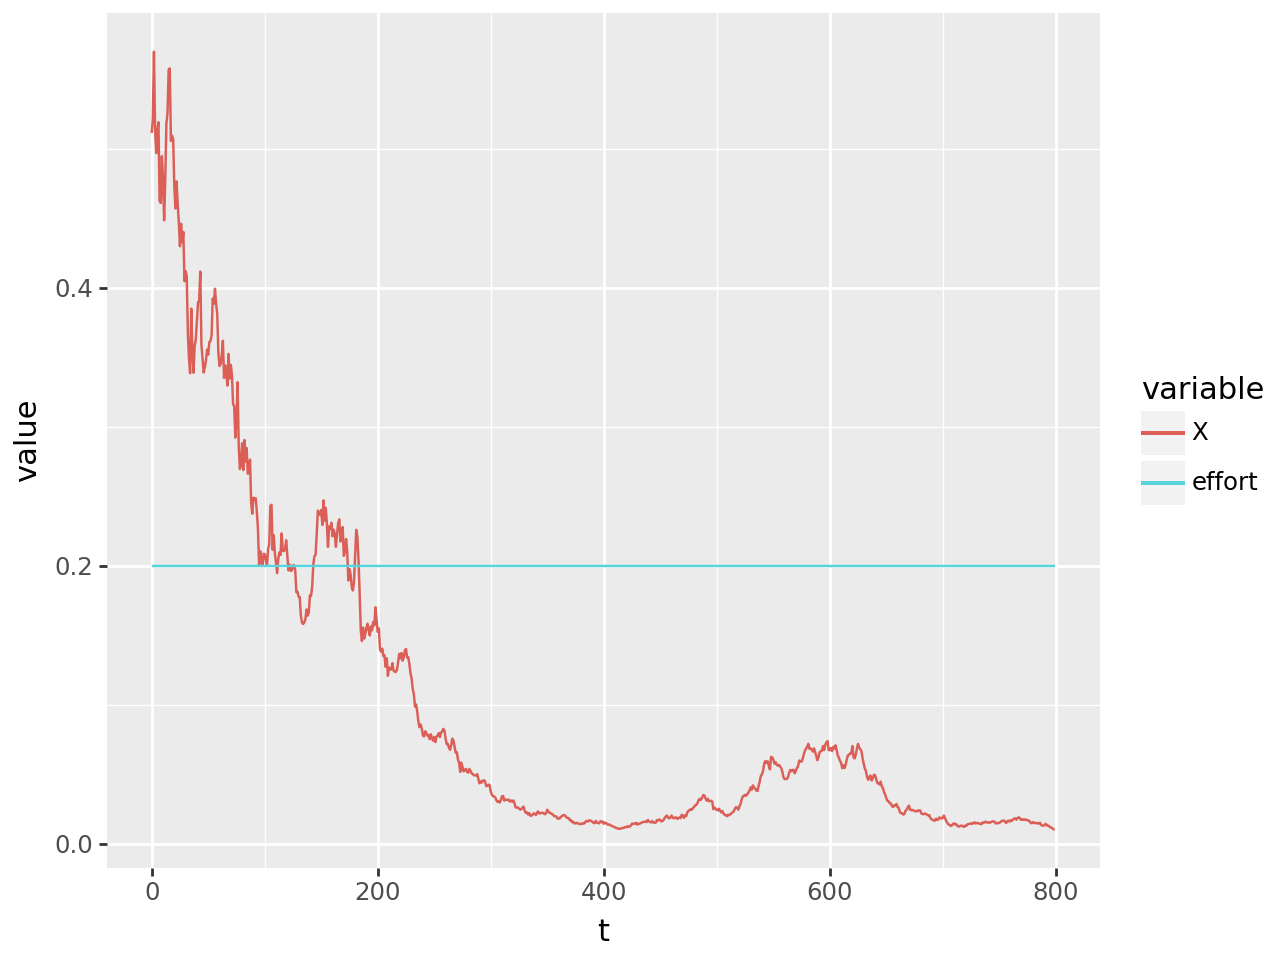

In [26]:
from utils import simulate
df, reward = simulate(bob, env)
print(reward)
plot_sim(df)

Of course we could imagine other strategies that do react to the observed state.  For instance, let's consider another agent, "tim", who uses a very different approach. Tim looks at the observed stock and compares it to some threshold.  If it is above the threshold, tim sends out every fishing boat available -- maximum effort. But if the stock falls below the threshold, tim stops fishing until the stock recovers:

In [27]:

class another_agent:
    def __init__(self, threshold):
        self.threshold = threshold

    def predict(self, obs, **kwargs):
        if obs < self.threshold:
            return 0
        else:
            return 1 


# This Agent is all or nothing:
tim = another_agent(0.2)

tim.predict(.4)

1

25.76840332762717


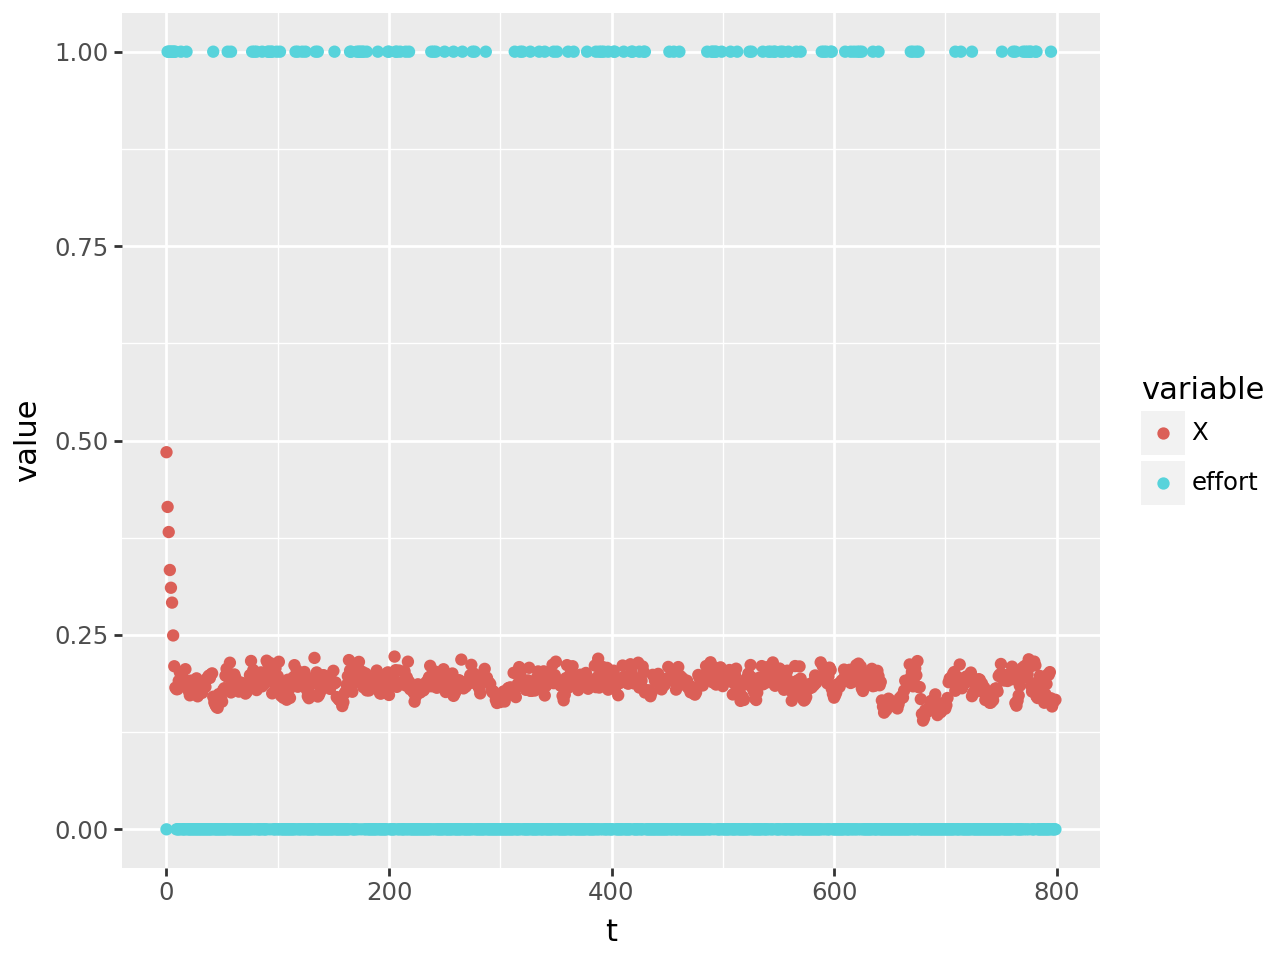

In [29]:
df, reward = simulate(tim, env)
print(reward)
plot_sim(df, geom="point")

Try modifying the parameters used by the above strategies, or constructing your own.  What is the largest reward you can achieve?  


While always fitting models to data has become de rigueur, theory can often teach us more by studying whole classes of models analytically.  For instance, for a large class of process-based models which we might postulate and seek to estimate parameters for, the optimal effort is determined by maximum sustainable yield theory, as initially demonstrated simultaneously by economist [Gordon (1954)](https://doi.org/10.1086/257497) & fisheries biologist [Schaefer (1954)](http://hdl.handle.net/1834/21257) in indpendent work in the same year on what would become their epynomous model.  
